In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set_style()
import wave
from scipy import signal
from scipy.fftpack import fft, ifft

In [3]:
path = '../exp/data'
dis = [20, 40, 80, 100]
db = [-1, 15, 30, 40]
repeat = list(range(5))

In [46]:
def load_wav(name):
    with wave.open(name, 'rb') as f:
        fs = f.getframerate()
        nframes = f.getnframes()
        str_data = f.readframes(nframes)
        nchannels = f.getnchannels()
        print(len(str_data))
        
    wave_data = np.frombuffer(str_data, dtype=np.int16)
    print(wave_data.shape)
    if nchannels == 2:
        wave_data = wave_data.reshape(2, -1)
        wave_data = wave_data.mean(axis=0)
    return fs, wave_data

def load_all(path, dis, db, repeat):
    for di in dis:
        for d in db:
            for r in repeat:
                name = r'{path}/{dis}cm_{db}db_{repeat}.wav'.format(**{
                    'path': path,
                    'dis': di,
                    'db': d,
                    'repeat': r
                })
                load_wav(name)

56000
(28000,)
[    0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0  1000     0     0 -1000     0     0     0     0     0
     0     0     0     0     0 -1000     0     0     0     0 -1000     0
     0  1000     0     0     0     0     0     0     0     0     0     0
  1000     0     0 -1000     0     0     0     0 -1000     0     0  1000
     0     0 -1000     0     0     0     0     0     0     0  1000     0
     0     0     0     0     0     0     0     0     0  1000     0     0
     0     0     0     0     0     0     0     0     0     0     0 -1000
     0     0     0     0]


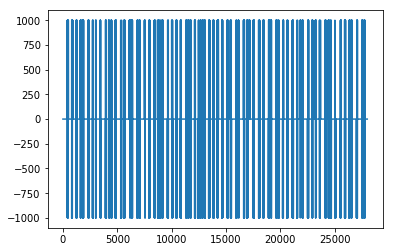

In [83]:
#load_all(path, dis, db, repeat)
fs, data = load_wav('./noise.wav')
print(data[1200:1300])
plt.plot(data)

In [85]:
def fda(x, floor, ceil, fs):
    print(fs)
    b, a = signal.butter(8, [2 * floor / fs, 2 * ceil / fs], 'bandpass')
    data = signal.filtfilt(b, a, x)
    print(data.shape)
    return data

48000
(28000,)


C:\Anaconda\lib\site-packages\scipy\signal\_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]


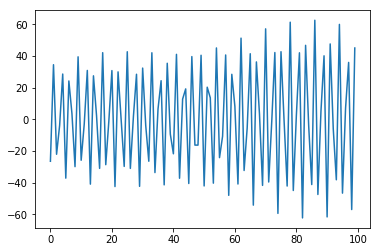

In [86]:
filted = fda(data, 17500, 18500, fs)
plt.plot(filted[1200:1300])

In [87]:
def dfft(data, f, fs):
    n = data.shape[0]
    window = 100
    impulse_fft = np.zeros((n, 1))
    for i in range(n - window):
        y = fft(data[i:i + window])
        y = np.abs(y)
        index_impulse = round(f / fs * window)
        impulse_fft[i] = np.max(y[index_impulse - 2:index_impulse + 3])
    return impulse_fft

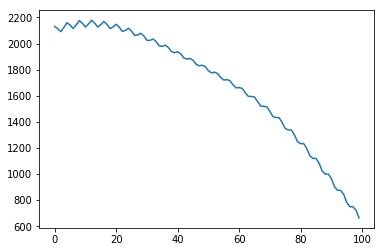

In [88]:
impulse = dfft(filted, 18000, fs)
plt.plot(impulse[1200:1300])

In [97]:
def smooth(a, window):
    a = a.squeeze()
    out = np.convolve(a, np.ones(window, dtype=int),'valid') / window
    r = np.arange(1, window - 1, 2)
    start = np.cumsum(a[:window - 1])[::2] / r
    stop = (np.cumsum(a[:-window:-1])[::2] / r)[::-1]
    return np.concatenate((start, out, stop))

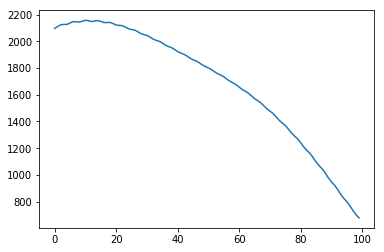

In [98]:
sm_data = smooth(impulse, 5)
plt.plot(sm_data[1200:1300])

In [99]:
def find_max(data, half_window):
    data = data / np.max(data)
    n = data.shape[0]
    position_impulse = []
    for i in range(half_window, n - half_window):
        if data[i] > 0.3 and data[i] == np.max(data[i - half_window:i + half_window + 1]):
            position_impulse.append(i)
    return position_impulse

In [100]:
raw_pos = find_max(data, 50)
impulse_pos = find_max(sm_data, 50)
print(impulse_pos)

[406, 820, 1210, 1577, 1804, 2990, 3430, 4195, 4399, 4777, 5279, 5621, 6123, 6309, 7000, 7483, 8395, 8684, 8910, 9120, 9605, 10001, 10395, 11287, 11520, 11647, 12095, 12399, 12589, 12985, 13428, 13811, 14214, 14614, 15073, 15404, 15870, 16098, 16595, 17060, 17516, 18004, 18409, 18878, 19604, 19795, 20586, 21107, 21528, 21782, 22493, 23632, 24373, 24560, 25038, 25503, 25905, 26305, 26511, 26976, 27502, 27706]


In [101]:
def decode(pos):
    N = len(pos)
    d = 100
    eps = 45
    message_2 = [-1] * ((N - 1) * 2)
    for i in range(N - 1):
        delta = pos[i + 1] - pos[i] - 100
        print(delta)
        if -eps < delta - d < eps:
            message_2[i * 2 - 1] = 0
            message_2[i * 2] = 0
        elif -eps < delta - d * 2 < eps:
            message_2[i * 2 - 1] = 0
            message_2[i * 2] = 1
        elif -eps < delta - d * 3 < eps:
            message_2[i * 2 - 1] = 1
            message_2[i * 2] = 0
        elif -eps < delta - d * 4 < eps:
            message_2[i * 2 - 1] = 1
            message_2[i * 2] = 1
    message_str = ''.join(map(str, message_2))
    print(message_str)

In [102]:
decode(impulse_pos)

314
290
267
127
1086
340
665
104
278
402
242
402
86
591
383
812
189
126
110
385
296
294
792
133
27
348
204
90
296
343
283
303
300
359
231
366
128
397
365
356
388
305
369
626
91
691
421
321
154
611
1039
641
87
378
365
302
300
106
365
426
104
0101000-1-110-1-1001011011100-1-111-1-1010000111010-1-100-1-1-1-10100101010101011011100111111111011-1-100-1-11110-1-1-1-1-1-1-1-10011111010001111001
